In [1]:
!pip install numpy
!pip install scikit-surprise

The directory '/Users/ivanmatis/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/ivanmatis/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/ivanmatis/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/ivanmatis/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with s

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import accuracy
import seaborn as sns
import numpy as np

# Laboratorio 2 - SR de factorización

En este laboratorio se ajustará un modelo de factorización utilizando el framework Surprise de Pandas https://surprise.readthedocs.io/en/stable/index.html

Los datos fueron previamente separados en conjunto de entrenamiento, validación y test. 


In [4]:
train_data=pd.read_csv('train',sep='::', names=['user_id','item_id','rating','timestamp'])
cv_data=pd.read_csv('cv',sep='::', names=['user_id','item_id','rating','timestamp'])
test_data=pd.read_csv('test',sep='::', names=['user_id','item_id','rating','timestamp'])

/Users/ivanmatis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/ivanmatis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/ivanmatis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine=

## 1 .Exploración de datasets de entrenamiento, validación y test

Corra las siguientes líneas y concluya sobre cómo estan armados estos datasets

In [5]:
train_data.head(5)

,user_id,item_id,rating,timestamp
0,181,930,1,878963275
1,13,72,4,882141727
2,13,181,5,882140354
3,181,619,3,878963086
4,181,334,1,878961749


In [6]:
cv_data.head(5)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
test_data.head(5)

,user_id,item_id,rating,timestamp
0,13,498,4,882139901
1,13,892,3,882774224
2,13,229,4,882397650
3,181,741,1,878962918
4,181,1015,1,878963121


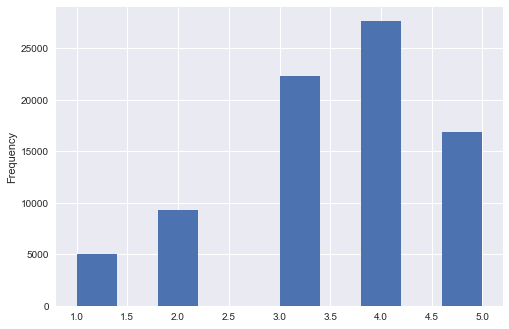

In [16]:
train_data.rating.plot.hist()

In [8]:
train_data.describe()

,user_id,item_id,rating,timestamp
count,81140.000000,81140.000000,81140.000000,8.114000e+04
mean,460.273047,430.530749,3.516207,8.834829e+08
std,265.245484,335.509074,1.126096,5.340285e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,259.750000,173.000000,3.000000,8.794481e+08
50%,437.000000,328.000000,4.000000,8.826785e+08
75%,671.000000,642.000000,4.000000,8.881927e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


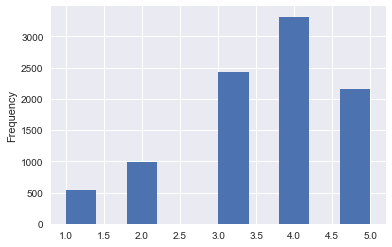

In [9]:
cv_data.rating.plot.hist()

In [10]:
cv_data.describe()

,user_id,item_id,rating,timestamp
count,9430.000000,9430.000000,9430.000000,9.430000e+03
mean,472.000000,400.800954,3.587805,8.837354e+08
std,272.234934,306.859789,1.120240,5.360562e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,236.000000,182.000000,3.000000,8.794515e+08
50%,472.000000,303.000000,4.000000,8.833904e+08
75%,708.000000,566.000000,4.000000,8.886378e+08
max,943.000000,1664.000000,5.000000,8.932866e+08


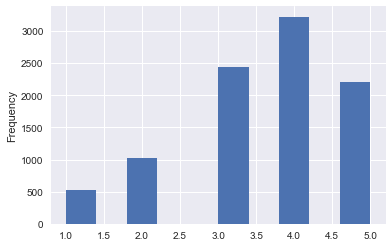

In [11]:
test_data.rating.plot.hist()

In [12]:
test_data.describe()

,user_id,item_id,rating,timestamp
count,9430.000000,9430.000000,9430.000000,9.430000e+03
mean,472.000000,407.231707,3.589396,8.837179e+08
std,272.234934,310.714759,1.123800,5.349370e+06
min,1.000000,1.000000,1.000000,8.747249e+08
25%,236.000000,187.000000,3.000000,8.794518e+08
50%,472.000000,304.000000,4.000000,8.833653e+08
75%,708.000000,582.000000,4.000000,8.886326e+08
max,943.000000,1661.000000,5.000000,8.932866e+08


In [13]:
print("Train size: "+str(train_data.shape))
print("CV size: "+str(cv_data.shape))
print("Test size: "+str(cv_data.shape))

Train size: (81140, 4)
CV size: (9430, 4)
Test size: (9430, 4)


# dispersión de la matriz

In [44]:
n_users = train_data.user_id.unique().shape[0]
n_items = train_data.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items) )

Number of users = 911 | Number of movies = 1672


In [47]:
len(train_data)

81140

In [46]:
sparsity=round(1.0-len(train_data)/float(n_users*n_items),3)
print ('The sparsity level of dataset is ' +  str(sparsity*100) + '%')

The sparsity level of dataset is 94.69999999999999%


## Lectura de dataset en framework surprise
El framework lee los dataframes de pandas, se crea un dataset por archivo para entrenar el modelo

In [14]:
reader = Reader(rating_scale=(1, 5))

In [15]:
#Lectura de datasets a partir de dataframes, se puede cargar directamente el archivo sin necesidad de pasar por dataframes
data_train = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
data_cv= Dataset.load_from_df(cv_data[['user_id', 'item_id', 'rating']], reader)
data_test= Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [16]:
#Se construyen los datasets de entrenamiento, aunque solo el primero es de entrenamiento es un 
# paso previo para poder crear datasets de validaciíon y de test

# build_full_trainset Do not split the dataset into folds and just return a trainset as is, built from the whole dataset.
data_train=data_train.build_full_trainset()

data_cv=data_cv.build_full_trainset()
data_test=data_test.build_full_trainset()

In [17]:
#Se construye dataset de test, se usa el de entrenamiento también para medir posteriormente el error en el conjunto de entrenamiento

#build_testset()
#Return a list of ratings that can be used as a testset in the test() method.

data_train_trainset=data_train.build_testset()
data_cv=data_cv.build_testset()
data_test=data_test.build_testset()

## 2 .Entrenamiento modelo SVD con Bias

El modelo toma como base en promedio global, en este caso es 3.5162

In [18]:
mean=data_train.global_mean
print(mean)

3.51620655657


La clase SVD recibe los siguientes parámetros:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
* n_factors: Número k de factores para realizar la recomendación
* n_epochs: Número de iteraciones a realizar sobre los datos
* biased: Si el modelo contempla los bias o solo la factorización
* lr_all: Tasa de aprendizaje del método
* reg_all: Parámetro de regularización
* init_mean y init_std_dev son los parámetros de la distribución usada para inicializar aleatoriamente los factores

Se prueba un modelo con bias sin regularización para k=5




In [19]:
algo=SVD(n_factors=5, n_epochs=200, biased=True, lr_all=0.005, reg_all=0, init_mean=0, init_std_dev=0.01,verbose=True)

In [20]:
algo.train(data_train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

Al finalizar el entrenamiento, se visualiza cómo quedo la matriz que representa a los usuarios ($p_u$) y la matriz que representa a los items ($q_i$)

In [21]:
pu=algo.pu

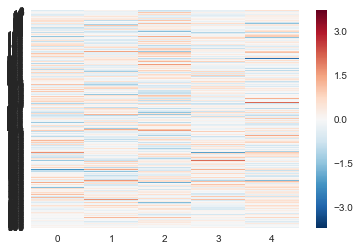

In [22]:
sns.heatmap(pu)

In [23]:
qi=algo.qi

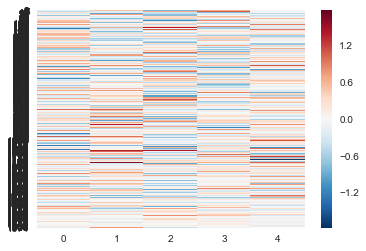

In [24]:
sns.heatmap(qi)

También se pueden visualizar los bias de usuarios e items $b_u$ y $b_i$

In [25]:
bi=algo.bi.reshape(algo.bi.shape[0],1)
bu=algo.bu.reshape(algo.bu.shape[0],1)

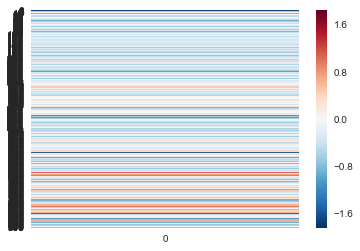

In [26]:
sns.heatmap(bu)

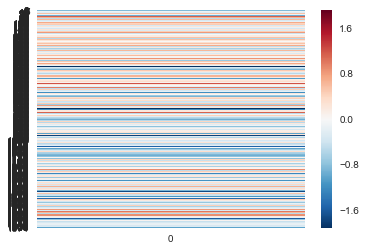

In [27]:
sns.heatmap(bi)

## Reconstrucción de matriz original

Una vez se realiza la factorización, se puede reconstruir la predicción para cada una de las coordenadas de la matriz original

$\hat{r}_{ui}= \mu + b_{i} + b_{u} + p_{u}\dot q_{i}^{T} $

In [28]:
reconstruct=(pu).dot((qi).T)+bu+bi.T+mean

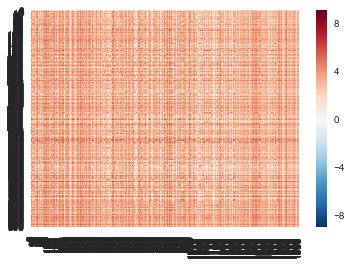

In [29]:
sns.heatmap(reconstruct)

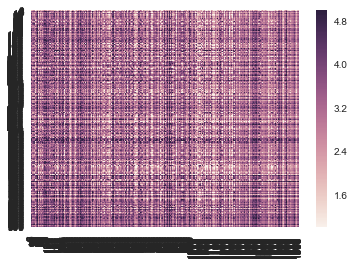

In [30]:
#como los valores se pasan de 5 y son menores a 1, se recorta la predicción
reconstruct=np.clip(reconstruct,1,5)
sns.heatmap(reconstruct)

Compare los resultados con la matriz original 

In [31]:
original=np.zeros((data_train.n_users , data_train.n_items))
for (u,i,r) in data_train.all_ratings():
        original[u][i]=r

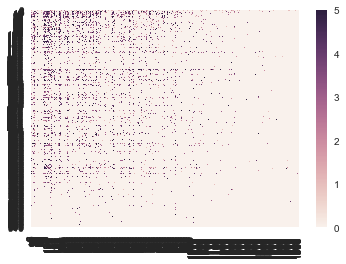

In [32]:
sns.heatmap(original)

### Se compara el error en las entradas conocidas de la matriz visualmente (error en conjunto de entrenamiento)

In [33]:
known_entries=original==0

In [34]:
reconstruct[known_entries]=0

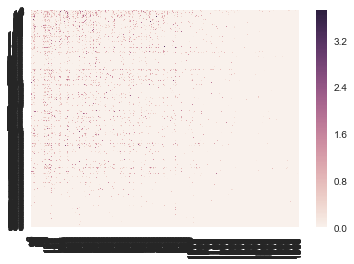

In [35]:
sns.heatmap(np.abs(original-reconstruct))

## 3. Evaluación de predicciones

A partir del modelo entrenado, se mide el error del modelo en el conjunto de entrenamiento, prueba y validación

In [36]:
predictions = algo.test(data_train_trainset)

In [37]:
predictions_cv=algo.test(data_cv)
predictions_test=algo.test(data_test)

In [38]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.7522


0.75220917534724607

In [39]:
accuracy.rmse(predictions_cv, verbose=True)

RMSE: 1.0069


1.0068919109742298

In [40]:
accuracy.rmse(predictions_test, verbose=True)

RMSE: 1.0210


1.0209908496437414

## 4. Selección de hiper-parámetros

Utilice este cuaderno para realizar los siguientes ajustes:

4.1 Aumente el número k de dimensiones de vector y documente los resultados. Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores (cree una gráfica donde muestre el efecto que tiene k sobre los errores)

4.2 Para un k fijo, aumente la regularización para diferentes valores [0.001,0.1,0.5,1,10]. Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores.

In [41]:
trainErr = []
cvErr = []
testErr = []
for k in range(1, 30):
    algo=SVD(n_factors=k, n_epochs=200, biased=True, lr_all=0.005, reg_all=0, init_mean=0, init_std_dev=0.01,verbose=True)
    algo.train(data_train)
    predictions = algo.test(data_train_trainset)
    predictions_cv=algo.test(data_cv)
    predictions_test=algo.test(data_test)
    trainErr.append(accuracy.rmse(predictions, verbose=True))
    cvErr.append(accuracy.rmse(predictions_cv, verbose=True))
    testErr.append(accuracy.rmse(predictions_test, verbose=True))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

RMSE: 0.8247
RMSE: 0.9802
RMSE: 0.9960
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing 

Processing epoch 197
Processing epoch 198
Processing epoch 199
RMSE: 0.7739
RMSE: 0.9955
RMSE: 1.0198
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processi

Processing epoch 194
Processing epoch 195
Processing epoch 196
Processing epoch 197
Processing epoch 198
Processing epoch 199
RMSE: 0.7321
RMSE: 1.0114
RMSE: 1.0389
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Proce

KeyboardInterrupt: 